In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from scipy.stats import yeojohnson
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import optuna
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn._oldcore')

In [4]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Load the dataset from Google Drive
import pandas as pd

# Specify the path to your CSV file in Google Drive
# Load the dataset
file_path = "/content/drive/My Drive/Filtered_PhiUSIIL_Phishing_URL_Dataset.csv"  # Update with the correct path if needed
df_new = pd.read_csv(file_path)


# Load the dataset into a DataFrame
df = pd.read_csv(file_path)

# Step 3: Display the first few rows of the dataset to confirm it loaded correctly
df.head()

Mounted at /content/drive


,URLLength,DomainLength,IsDomainIP,NoOfSubDomain,NoOfObfuscatedChar,IsHTTPS,NoOfURLRedirect,HasExternalFormSubmit,HasHiddenFields,HasPasswordField,HasSocialNet,NoOfPopup,NoOfiFrame,DomainTitleMatchScore,URLTitleMatchScore,label
0,31,24,0,1,0,1,0,0,1,0,0,0,1,0.000000,0.000000,1
1,23,16,0,1,0,1,0,0,0,0,1,0,0,55.555556,55.555556,1
2,29,22,0,2,0,1,0,0,1,0,0,0,0,46.666667,46.666667,1
3,26,19,0,1,0,1,0,0,1,0,1,1,12,0.000000,0.000000,1
4,33,26,0,1,0,1,1,0,1,0,1,0,2,100.000000,100.000000,1


In [5]:
import pandas as pd

# Assuming df is your dataset
columns_to_drop = ['DomainLength', 'DomainTitleMatchScore']

# Drop the specified columns
df = df.drop(columns=columns_to_drop, errors='ignore')

# Display the first few rows after dropping columns
print(df.head())


   URLLength  IsDomainIP  NoOfSubDomain  NoOfObfuscatedChar  IsHTTPS  \
0         31           0              1                   0        1   
1         23           0              1                   0        1   
2         29           0              2                   0        1   
3         26           0              1                   0        1   
4         33           0              1                   0        1   

   NoOfURLRedirect  HasExternalFormSubmit  HasHiddenFields  HasPasswordField  \
0                0                      0                1                 0   
1                0                      0                0                 0   
2                0                      0                1                 0   
3                0                      0                1                 0   
4                1                      0                1                 0   

   HasSocialNet  NoOfPopup  NoOfiFrame  URLTitleMatchScore  label  
0             0   

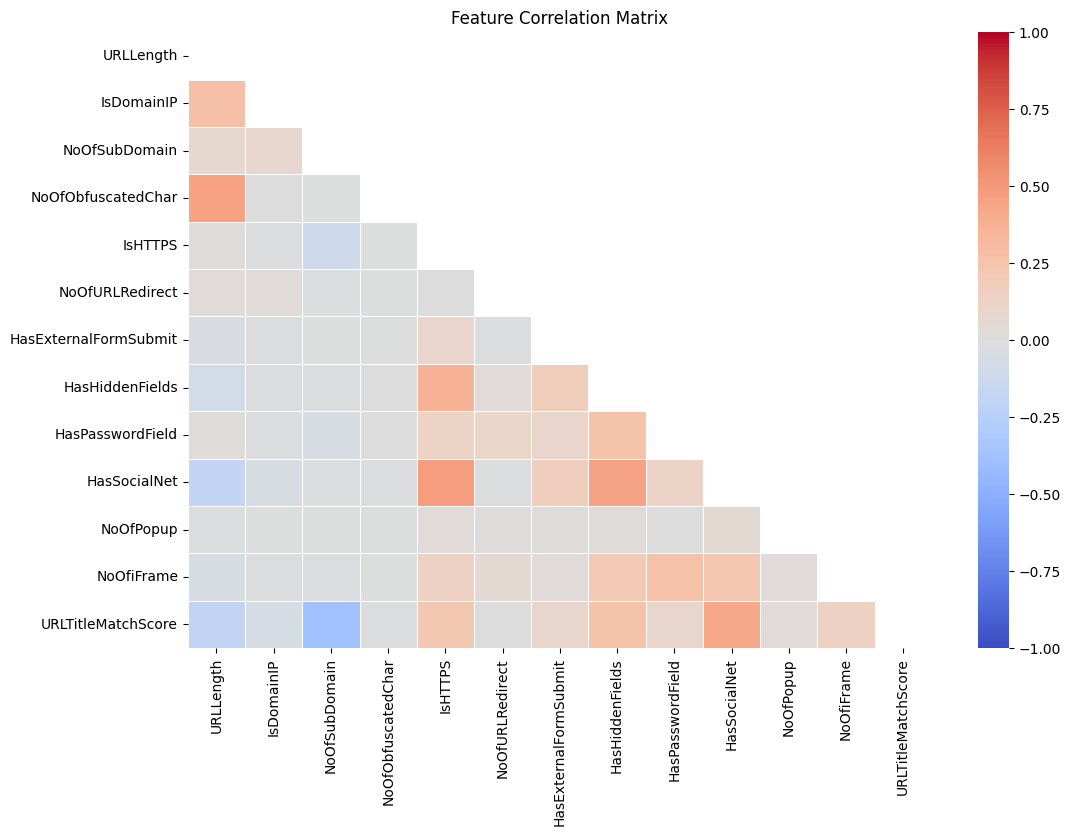

Features removed due to high correlation: set()
Features removed due to low variance: ['IsDomainIP']


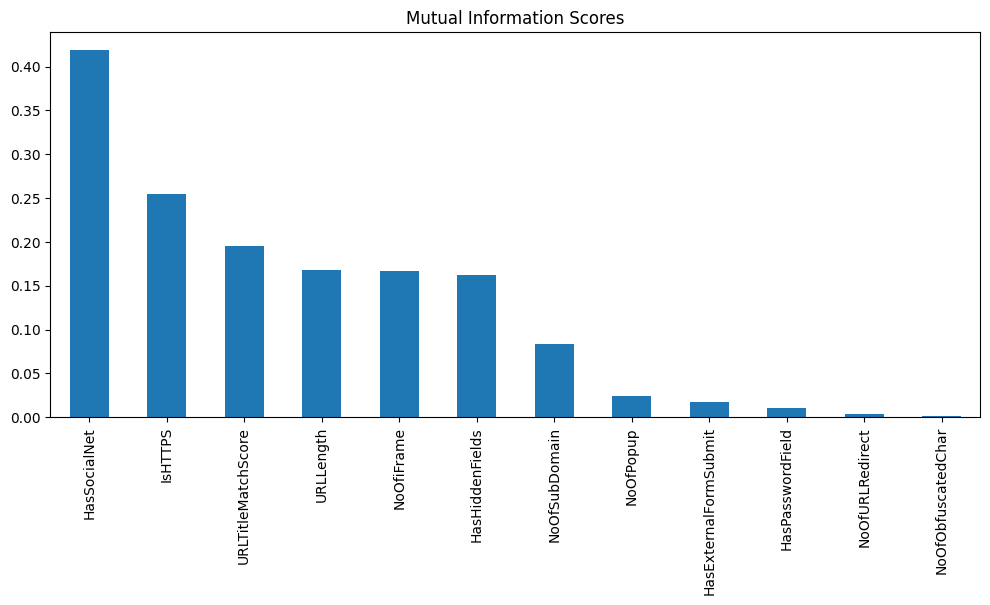

Selected Features by RFE: ['URLLength', 'NoOfSubDomain', 'IsHTTPS', 'HasSocialNet', 'URLTitleMatchScore']


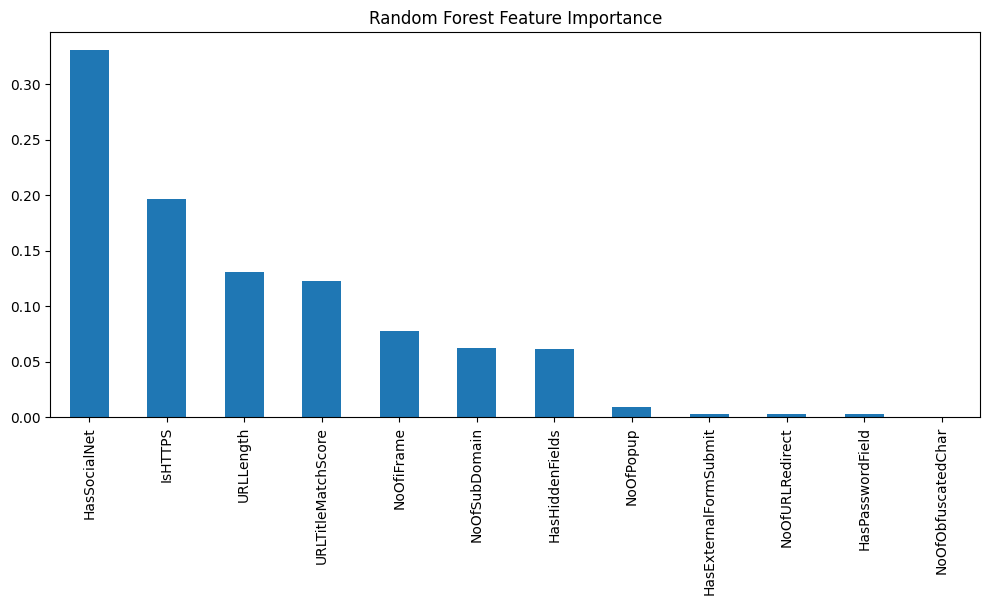

Final Selected Features: {'IsHTTPS', 'URLLength', 'HasSocialNet', 'NoOfSubDomain', 'URLTitleMatchScore'}


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold, RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = "/content/drive/My Drive/Filtered_PhiUSIIL_Phishing_URL_Dataset.csv"  # Update with the correct path if needed
df_new = pd.read_csv(file_path)

# Drop unwanted columns
columns_to_drop = ['DomainLength', 'DomainTitleMatchScore']
df_new = df_new.drop(columns=columns_to_drop, errors='ignore')

# Separate features and target
X = df_new.drop(columns=['label'])
y = df_new['label']

# 1. Correlation Analysis (Remove Highly Correlated Features)
corr_matrix = X.corr()

# Improve visualization by masking upper triangle
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap="coolwarm", vmax=1, vmin=-1, linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# Remove highly correlated features (Threshold: 0.8)
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_features.add(corr_matrix.columns[i])

X = X.drop(columns=high_corr_features)
print("Features removed due to high correlation:", high_corr_features)

# 2. Variance Thresholding (Remove Low Variance Features)
selector = VarianceThreshold(threshold=0.01)
X_high_variance = selector.fit_transform(X)
low_variance_features = list(X.columns[~selector.get_support()])
X = X.loc[:, selector.get_support()]
print("Features removed due to low variance:", low_variance_features)

# 3. Feature Importance using Mutual Information
mi_scores = mutual_info_classif(X, y)
mi_scores_series = pd.Series(mi_scores, index=X.columns)
plt.figure(figsize=(12, 5))
mi_scores_series.sort_values(ascending=False).plot(kind='bar', title="Mutual Information Scores")
plt.xticks(rotation=90)
plt.show()

# 4. Recursive Feature Elimination (RFE) using Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rf_model, n_features_to_select=5)  # Selecting top 5 features
rfe.fit(X, y)

selected_features_rfe = X.columns[rfe.support_]
print("Selected Features by RFE:", selected_features_rfe.tolist())

# 5. Feature Importance using Random Forest
rf_model.fit(X, y)
importances = rf_model.feature_importances_
feature_importance_series = pd.Series(importances, index=X.columns)

plt.figure(figsize=(12, 5))
feature_importance_series.sort_values(ascending=False).plot(kind='bar', title="Random Forest Feature Importance")
plt.xticks(rotation=90)
plt.show()

# Final selected features
final_features = set(selected_features_rfe)
print("Final Selected Features:", final_features)


In [4]:
print(f"{df.dtypes}\n")
print(f"Dimension: {df.shape[0]} x {df.shape[1]}\n")

datatype_counts = df.dtypes.value_counts()
for dtype, count in datatype_counts.items():
    print(f"{dtype}: {count} columns")

URLLength                  int64
IsDomainIP                 int64
NoOfSubDomain              int64
NoOfObfuscatedChar         int64
IsHTTPS                    int64
NoOfURLRedirect            int64
HasExternalFormSubmit      int64
HasHiddenFields            int64
HasPasswordField           int64
HasSocialNet               int64
NoOfPopup                  int64
NoOfiFrame                 int64
URLTitleMatchScore       float64
label                      int64
dtype: object

Dimension: 235795 x 14

int64: 13 columns
float64: 1 columns


In [5]:
null = df.isnull().sum()
for i in range(len(df.columns)):
    print(f"{df.columns[i]}: {null[i]} ({(null[i]/len(df))*100}%)")
total_missing = null.sum()

URLLength: 0 (0.0%)
IsDomainIP: 0 (0.0%)
NoOfSubDomain: 0 (0.0%)
NoOfObfuscatedChar: 0 (0.0%)
IsHTTPS: 0 (0.0%)
NoOfURLRedirect: 0 (0.0%)
HasExternalFormSubmit: 0 (0.0%)
HasHiddenFields: 0 (0.0%)
HasPasswordField: 0 (0.0%)
HasSocialNet: 0 (0.0%)
NoOfPopup: 0 (0.0%)
NoOfiFrame: 0 (0.0%)
URLTitleMatchScore: 0 (0.0%)
label: 0 (0.0%)


<ipython-input-5-a1cfb353df18>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"{df.columns[i]}: {null[i]} ({(null[i]/len(df))*100}%)")


In [49]:
def is_continuous(series):
    return series.nunique() > 10

continuous_columns = [col for col in df.columns if is_continuous(df[col])]

In [50]:
cols = df.columns.to_list()
cols.remove('label')

X = df[cols]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Selecting relevant features
selected_features = [
    "DomainLength", "NoOfSubDomain", "NoOfObfuscatedChar", "NoOfURLRedirect", "NoOfPopup", "NoOfiFrame",
    "DomainTitleMatchScore", "LetterRatioInURL", "DegitRatioInURL", "ObfuscationRatio",
    "IsDomainIP", "IsHTTPS", "HasObfuscation", "HasPasswordField", "HasSocialNet",
    "HasExternalFormSubmit", "HasHiddenFields"
]

# Extract selected features and target label
X = df_new[selected_features]
y = df_new['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Get feature importances
feature_importances = dict(zip(selected_features, rf_model.feature_importances_))

# Sort and display top 10 important features
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
print(sorted_features[:10])

NameError: name 'df_new' is not defined

Class Distribution:
 label
1    134850
0    100945
Name: count, dtype: int64

Class Distribution Percentage:
 label
1    57.189508
0    42.810492
Name: count, dtype: float64


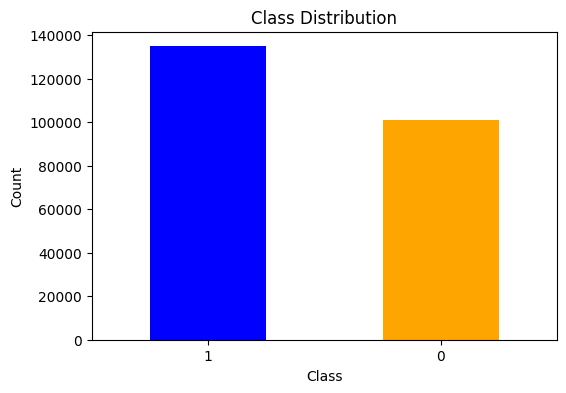


✅ The dataset is balanced!


In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = "/content/drive/My Drive/Filtered_PhiUSIIL_Phishing_URL_Dataset.csv"  # Update with the correct path if needed
df = pd.read_csv(file_path)

# Check class distribution
class_counts = df['label'].value_counts()

# Print class distribution
print("Class Distribution:\n", class_counts)

# Calculate class proportions
class_percentages = (class_counts / class_counts.sum()) * 100
print("\nClass Distribution Percentage:\n", class_percentages)

# Plot class distribution
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.xticks(rotation=0)
plt.show()

# Check if dataset is balanced (considering 40-60% threshold for imbalance)
threshold = 0.4  # 40%
min_class_ratio = class_counts.min() / class_counts.max()

if min_class_ratio < threshold:
    print("\n⚠️ The dataset is imbalanced!")
else:
    print("\n✅ The dataset is balanced!")


In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
file_path = "/content/drive/My Drive/Filtered_PhiUSIIL_Phishing_URL_Dataset.csv"  # Update with correct path
df = pd.read_csv(file_path)

# Drop unwanted columns (if needed)
columns_to_drop = ['DomainLength', 'DomainTitleMatchScore']
df = df.drop(columns=columns_to_drop, errors='ignore')

# Define features and target
X = df.drop(columns=['label'])  # Features
y = df['label']  # Target variable

# Split dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     30284
           1       0.99      0.99      0.99     40455

    accuracy                           0.99     70739
   macro avg       0.99      0.99      0.99     70739
weighted avg       0.99      0.99      0.99     70739



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5158/5158 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9718 - loss: 0.0845 - val_accuracy: 0.9870 - val_loss: 0.0371
Epoch 2/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.9867 - loss: 0.0393 - val_accuracy: 0.9867 - val_loss: 0.0367
Epoch 3/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - accuracy: 0.9871 - loss: 0.0385 - val_accuracy: 0.9873 - val_loss: 0.0366
Epoch 4/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.9867 - loss: 0.0389 - val_accuracy: 0.9870 - val_loss: 0.0362
Epoch 5/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.9869 - loss: 0.0393 - val_accuracy: 0.9878 - val_loss: 0.0359
Epoch 6/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 45s 6ms/step - accuracy: 0.9872 - loss: 0.0383 - val_accuracy: 0.9877 - val_loss: 0.0357
Epoch 7/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.9871 - loss: 0.0376 - val_accuracy: 0.9868 - val_loss: 0.0371
Epoch 8/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.9876 - loss: 0.0365 - val

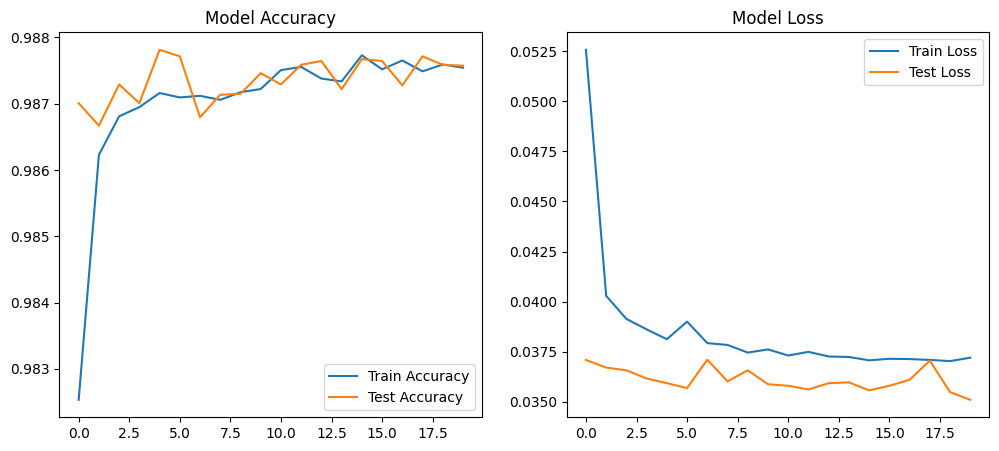

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
file_path = "/content/drive/My Drive/Filtered_PhiUSIIL_Phishing_URL_Dataset.csv"  # Update with correct path
df = pd.read_csv(file_path)

# Drop unwanted columns (if needed)
columns_to_drop = ['DomainLength', 'DomainTitleMatchScore']
df = df.drop(columns=columns_to_drop, errors='ignore')

# Define features and target
X = df.drop(columns=['label']).values  # Features
y = df['label'].values  # Target variable

# Normalize feature values
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape input to fit RNN format (samples, time steps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))  # 1 time step for each feature vector

# Split dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define the RNN model
model = Sequential([
    SimpleRNN(64, activation='relu', return_sequences=True, input_shape=(1, X.shape[2])),
    Dropout(0.2),
    SimpleRNN(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate model performance
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.2f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.title("Model Loss")

plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - accuracy: 0.9379 - loss: 0.1395 - val_accuracy: 0.9682 - val_loss: 0.0787
Epoch 2/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 45s 9ms/step - accuracy: 0.9643 - loss: 0.0824 - val_accuracy: 0.9678 - val_loss: 0.0743
Epoch 3/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 86s 9ms/step - accuracy: 0.9648 - loss: 0.0804 - val_accuracy: 0.9691 - val_loss: 0.0735
Epoch 4/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - accuracy: 0.9666 - loss: 0.0782 - val_accuracy: 0.9691 - val_loss: 0.0727
Epoch 5/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 85s 9ms/step - accuracy: 0.9674 - loss: 0.0760 - val_accuracy: 0.9690 - val_loss: 0.0733
Epoch 6/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - accuracy: 0.9667 - loss: 0.0754 - val_accuracy: 0.9687 - val_loss: 0.0720
Epoch 7/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 84s 9ms/step - accuracy: 0.9672 - loss: 0.0752 - val_accuracy: 0.9688 - val_loss: 0.0721
Epoch 8/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 48s 9ms/step - accuracy: 0.9674 - loss: 0

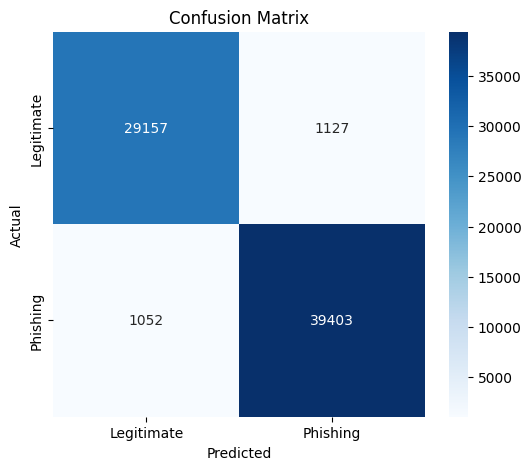

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Load dataset
file_path = "/content/drive/My Drive/Filtered_PhiUSIIL_Phishing_URL_Dataset.csv"  # Update with correct path
df = pd.read_csv(file_path)

# Drop unwanted columns (if needed)
columns_to_drop = ['DomainLength', 'DomainTitleMatchScore']
df = df.drop(columns=columns_to_drop, errors='ignore')

# Define features and target
X = df.drop(columns=['label']).values  # Features
y = df['label'].values  # Target variable

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape input for CNN+GRU (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))  # 1 channel for CNN

# Split dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define CNN + GRU Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    GRU(64, return_sequences=False, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Load dataset
file_path = "/content/drive/My Drive/Filtered_PhiUSIIL_Phishing_URL_Dataset.csv"  # Update with correct path
df = pd.read_csv(file_path)

# Drop unwanted columns (if needed)
columns_to_drop = ['DomainLength', 'DomainTitleMatchScore']
df = df.drop(columns=columns_to_drop, errors='ignore')

# Define features and target
X = df.drop(columns=['label']).values  # Features
y = df['label'].values  # Target variable

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape input for CNN (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))  # 1 channel for CNN

# Split dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define CNN Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

# Make predictions
y_pred_cnn = (model.predict(X_test) > 0.5).astype(int)

# Print classification report
print("CNN Model Classification Report")
print(classification_report(y_test, y_pred_cnn))

# Print confusion matrix
print("CNN Model Confusion Matrix")
print(confusion_matrix(y_test, y_pred_cnn))



Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5158/5158 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9342 - loss: 0.1544 - val_accuracy: 0.9649 - val_loss: 0.0839
Epoch 2/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.9608 - loss: 0.0937 - val_accuracy: 0.9637 - val_loss: 0.0842
Epoch 3/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.9606 - loss: 0.0924 - val_accuracy: 0.9613 - val_loss: 0.0829
Epoch 4/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - accuracy: 0.9610 - loss: 0.0898 - val_accuracy: 0.9653 - val_loss: 0.0822
Epoch 5/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.9619 - loss: 0.0894 - val_accuracy: 0.9653 - val_loss: 0.0837
Epoch 6/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.9620 - loss: 0.0876 - val_accuracy: 0.9643 - val_loss: 0.0817
Epoch 7/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.9627 - loss: 0.0875 - val_accuracy: 0.9635 - val_loss: 0.0827
Epoch 8/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.9628 - loss: 0.0867 - val

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset
file_path = "/content/drive/My Drive/Filtered_PhiUSIIL_Phishing_URL_Dataset.csv"  # Update with correct path
df = pd.read_csv(file_path)

# Drop unwanted columns
columns_to_drop = ['DomainLength', 'DomainTitleMatchScore']
df = df.drop(columns=columns_to_drop, errors='ignore')

# Define features and target
X = df.drop(columns=['label']).values  # Features
y = df['label'].values  # Target variable

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define and train SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)

# Print classification report
print("SVM Model Classification Report")
print(classification_report(y_test, y_pred_svm))

# Print confusion matrix
print("SVM Model Confusion Matrix")
print(confusion_matrix(y_test, y_pred_svm))
# Print final accuracy
final_accuracy = accuracy_score(y_test, y_pred_bagging)
print(f"Final Accuracy: {final_accuracy:.4f}")



SVM Model Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     30284
           1       0.99      0.98      0.99     40455

    accuracy                           0.99     70739
   macro avg       0.98      0.99      0.99     70739
weighted avg       0.99      0.99      0.99     70739

SVM Model Confusion Matrix
[[29930   354]
 [  663 39792]]
Final Accuracy: 0.9882


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load dataset
file_path = "/content/drive/My Drive/Filtered_PhiUSIIL_Phishing_URL_Dataset.csv"  # Update with correct path
df = pd.read_csv(file_path)

# Drop unwanted columns
columns_to_drop = ['DomainLength', 'DomainTitleMatchScore']
df = df.drop(columns=columns_to_drop, errors='ignore')

# Define features and target
X = df.drop(columns=['label']).values  # Features
y = df['label'].values  # Target variable

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define and train Bagging Classifier with Decision Trees
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),  # ✅ FIX: Use `estimator` instead of `base_estimator`
    n_estimators=50,
    random_state=42
)
bagging_model.fit(X_train, y_train)

# Make predictions
y_pred_bagging = bagging_model.predict(X_test)

# Print classification report
print("Bagging Model Classification Report")
print(classification_report(y_test, y_pred_bagging))

# Print confusion matrix
print("Bagging Model Confusion Matrix")
print(confusion_matrix(y_test, y_pred_bagging))

# Print final accuracy
final_accuracy = accuracy_score(y_test, y_pred_bagging)
print(f"Final Accuracy: {final_accuracy:.4f}")


Bagging Model Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     30284
           1       0.99      0.99      0.99     40455

    accuracy                           0.99     70739
   macro avg       0.99      0.99      0.99     70739
weighted avg       0.99      0.99      0.99     70739

Bagging Model Confusion Matrix
[[29939   345]
 [  491 39964]]
Final Accuracy: 0.9882


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load dataset
file_path = "/content/drive/My Drive/Filtered_PhiUSIIL_Phishing_URL_Dataset.csv"  # Update with correct path
df = pd.read_csv(file_path)

# Drop unwanted columns
columns_to_drop = ['DomainLength', 'DomainTitleMatchScore']
df = df.drop(columns=columns_to_drop, errors='ignore')

# Define features and target
X = df.drop(columns=['label']).values  # Features
y = df['label'].values  # Target variable

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define and train Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(
    n_estimators=100,   # Number of boosting stages
    learning_rate=0.1,  # Step size shrinkage
    max_depth=3,        # Maximum depth of individual estimators
    random_state=42
)
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)

# Print classification report
print("Gradient Boosting Classification Report")
print(classification_report(y_test, y_pred_gb))

# Print confusion matrix
print("Gradient Boosting Confusion Matrix")
print(confusion_matrix(y_test, y_pred_gb))

# Print final accuracy
final_accuracy = accuracy_score(y_test, y_pred_gb)
print(f"Final Accuracy: {final_accuracy:.4f}")


Gradient Boosting Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     30284
           1       0.99      0.99      0.99     40455

    accuracy                           0.99     70739
   macro avg       0.99      0.99      0.99     70739
weighted avg       0.99      0.99      0.99     70739

Gradient Boosting Confusion Matrix
[[29923   361]
 [  553 39902]]
Final Accuracy: 0.9871


In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Load dataset
file_path = "/content/drive/My Drive/Filtered_PhiUSIIL_Phishing_URL_Dataset.csv"  # Update with correct path
df = pd.read_csv(file_path)

# Drop unwanted columns
columns_to_drop = ['DomainLength', 'DomainTitleMatchScore']
df = df.drop(columns=columns_to_drop, errors='ignore')

# Define features and target
X = df.drop(columns=['label']).values  # Features
y = df['label'].values  # Target variable

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape input for GRU (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))  # 1 channel for GRU

# Split dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define GRU Model
model = Sequential([
    GRU(64, return_sequences=False, input_shape=(X.shape[1], 1)),  # Single GRU layer
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_pred_gru = (model.predict(X_test) > 0.5).astype(int)

# Print classification report
print("GRU Model Classification Report")
print(classification_report(y_test, y_pred_gru))

# Print confusion matrix
print("GRU Model Confusion Matrix")
print(confusion_matrix(y_test, y_pred_gru))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5158/5158 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - accuracy: 0.9593 - loss: 0.1078 - val_accuracy: 0.9861 - val_loss: 0.0395
Epoch 2/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 52s 10ms/step - accuracy: 0.9856 - loss: 0.0424 - val_accuracy: 0.9866 - val_loss: 0.0379
Epoch 3/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 53s 10ms/step - accuracy: 0.9866 - loss: 0.0395 - val_accuracy: 0.9869 - val_loss: 0.0369
Epoch 4/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 85s 11ms/step - accuracy: 0.9865 - loss: 0.0398 - val_accuracy: 0.9861 - val_loss: 0.0378
Epoch 5/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 81s 11ms/step - accuracy: 0.9863 - loss: 0.0405 - val_accuracy: 0.9865 - val_loss: 0.0369
Epoch 6/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 80s 10ms/step - accuracy: 0.9862 - loss: 0.0411 - val_accuracy: 0.9862 - val_loss: 0.0375
Epoch 7/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 55s 11ms/step - accuracy: 0.9870 - loss: 0.0396 - val_accuracy: 0.9870 - val_loss: 0.0366
Epoch 8/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - accuracy: 0.9867 - loss: 0.03

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load dataset
file_path = "/content/drive/My Drive/Filtered_PhiUSIIL_Phishing_URL_Dataset.csv"  # Update with correct path
df = pd.read_csv(file_path)

# Drop unwanted columns
columns_to_drop = ['DomainLength', 'DomainTitleMatchScore']
df = df.drop(columns=columns_to_drop, errors='ignore')

# Define features and target
X = df.drop(columns=['label']).values  # Features
y = df['label'].values  # Target variable

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape for LSTM (samples, time steps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))  # Assuming each row is a sequence of 1 time step

# Split dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),  # LSTM layer
    Dropout(0.2),  # Dropout for regularization
    LSTM(32, return_sequences=False),  # Another LSTM layer
    Dropout(0.2),
    Dense(16, activation='relu'),  # Fully connected layer
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make predictions
y_pred_lstm = (model.predict(X_test) > 0.5).astype("int32").flatten()

# Print classification report
print("LSTM Classification Report")
print(classification_report(y_test, y_pred_lstm))

# Print confusion matrix
print("LSTM Confusion Matrix")
print(confusion_matrix(y_test, y_pred_lstm))

# Print final accuracy
final_accuracy = accuracy_score(y_test, y_pred_lstm)
print(f"Final Accuracy: {final_accuracy:.4f}")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5158/5158 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9772 - loss: 0.0897 - val_accuracy: 0.9867 - val_loss: 0.0382
Epoch 2/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.9864 - loss: 0.0394 - val_accuracy: 0.9861 - val_loss: 0.0370
Epoch 3/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.9866 - loss: 0.0398 - val_accuracy: 0.9872 - val_loss: 0.0359
Epoch 4/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.9875 - loss: 0.0371 - val_accuracy: 0.9871 - val_loss: 0.0363
Epoch 5/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.9873 - loss: 0.0371 - val_accuracy: 0.9868 - val_loss: 0.0374
Epoch 6/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 43s 6ms/step - accuracy: 0.9867 - loss: 0.0385 - val_accuracy: 0.9871 - val_loss: 0.0359
Epoch 7/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.9877 - loss: 0.0362 - val_accuracy: 0.9865 - val_loss: 0.0367
Epoch 8/20
5158/5158 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.9869 - loss: 0.0375 - val